**18. Building an ANN with end to end workflow in PyTorch**

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split

import numpy as np
import torch as tr
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# set random seeds for reproducibility
random_seed = 14

In [3]:
df = pd.read_csv('datasets/fmnist_small.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,125,72,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,0,2,0,0,210,228,228,233,0,0,0,0,0,0,0,0,0,31,81,133,184,201,190,117,0,0,2,1,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,43,117,34,15,24,33,117,80,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,51,144,152,...,157,158,161,148,159,58,0,6,0,0,0,0,0,0,0,0,0,4,0,60,143,143,148,146,152,152,148,148,147,145,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,0,0,0,2,0,33,114,37,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,11,17,13,13,11,10,7,5,5,5,7,0,0,0,1,0,0,41,69,88,86,94,106,114,118,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,0,2,0,58,145,114,10,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,...,165,153,155,134,143,172,215,62,0,0,0,0,0,0,0,0,10,190,178,194,209,211,209,205,211,215,213,217,225,228,213,203,174,151,188,10,0,0,0,0


*Data preprocessing and DataLoader creation*

In [39]:
# getting data as numpy arrays
X = df.drop(columns=['label']).to_numpy()
y = df['label'].to_numpy()

class_labels =  ["T-shirt/top",
                "Trouser",
                "Pullover",
                "Dress",
                "Coat",
                "Sandal",
                "Shirt",
                "Sneaker",
                "Bag",
                "Ankle boot"]

# perform train-test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

# convert the arrays into pytorch tensors
X_train_tensor = tr.tensor(X_train, dtype= tr.float32)
X_test_tensor = tr.tensor(X_test, dtype= tr.float32) 
y_train_tensor = tr.tensor(y_train, dtype= tr.long) 
y_test_tensor = tr.tensor(y_test, dtype= tr.long) 

# creating dataset class
class FMNIST_DATASET(Dataset):
    def __init__(self,X,y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        return self.normalize(self.X[index]),self.y[index]

    def normalize(self,X):
        return (X/255.0).astype(np.float32)
    
train_dataset = FMNIST_DATASET(X_train,y_train)
test_dataset = FMNIST_DATASET(X_test,y_test)


BATCH_SIZE = 32
train_loader = DataLoader(train_dataset,batch_size= BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset,batch_size= BATCH_SIZE, shuffle = False)

*Image Visualization*

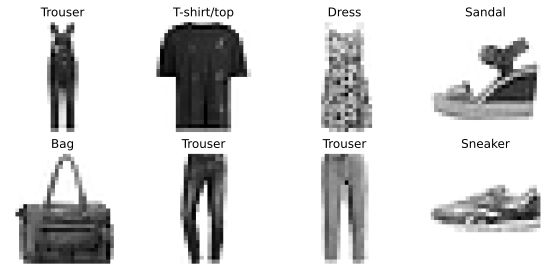

In [26]:
fig,axes = plt.subplots(2,4,figsize = (8,4))

images,labels = next(iter(train_loader))


for i,ax in enumerate(axes.flat):
    img = images[i].reshape(28,28)
    ax.imshow(img,cmap = 'binary')
    ax.axis('off')
    ax.set_title(f'{class_labels[labels[i]]}')

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

*Neural Network Creation*

**Notes:**
* PyTorch's CrossEntropyLoss has internal implementation of softmax, hence no explict need to add softmax.
* `optimizer.grad.zero_()`, optimizer doesn't have a attribute `.grad`, hence we do `optimizer.zero_grad()`

In [29]:
class FMNIST_NET(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear1 = nn.Linear(in_features=784,out_features=128)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(in_features=128,out_features=64)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(in_features=64,out_features=10)
        
    def forward(self,x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        return x

# from torchinfo import summary
# demo_model = FMNIST_NET()
# summary(demo_model)

In [30]:
# learning rate and epochs
lr = 1e-3
epochs = 100

# instantiating the model
fnet = FMNIST_NET()

# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = tr.optim.Adam(fnet.parameters(), lr = lr)

In [40]:
%%time

# training loop
for epochi in range(epochs):
    fnet.train()
    batch_loss = []
    for X_batch,y_batch in train_loader:
        # forward pass
        y_pred = fnet(X_batch)

        # loss calculation
        loss = loss_fn(y_pred,y_batch)
        batch_loss.append(loss.item())

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # upgrade parameters
        optimizer.step()

    mean_batch_loss = np.mean(batch_loss)
    
    # perform validation
    fnet.eval()
    val_correct = 0
    val_total = 0

    with tr.no_grad(): # disable gradient tracking
        for X_val,y_val in test_loader:
            y_pred = fnet(X_val)
            preds = tr.argmax(y_pred,dim=1)
            val_correct += (preds == y_val).sum().item()
            val_total += y_val.size(0)
    val_acc = (val_correct / val_total)*100

    print(f'Epoch: {epochi+1}, Loss: {mean_batch_loss}, Val Accuracy:{val_acc:.2f}%')

Epoch: 1, Loss: 1.0629572647809982, Val Accuracy:74.08%
Epoch: 2, Loss: 0.6600574590762456, Val Accuracy:79.58%
Epoch: 3, Loss: 0.5451922359069189, Val Accuracy:81.50%
Epoch: 4, Loss: 0.4907349074880282, Val Accuracy:82.00%
Epoch: 5, Loss: 0.46048629154761633, Val Accuracy:76.58%
Epoch: 6, Loss: 0.42988792568445205, Val Accuracy:85.00%
Epoch: 7, Loss: 0.40173486118515334, Val Accuracy:84.33%
Epoch: 8, Loss: 0.37242511947949725, Val Accuracy:84.25%
Epoch: 9, Loss: 0.3546919818719228, Val Accuracy:84.92%
Epoch: 10, Loss: 0.33647319753964744, Val Accuracy:83.58%
Epoch: 11, Loss: 0.32421276703476903, Val Accuracy:84.25%
Epoch: 12, Loss: 0.3018023968736331, Val Accuracy:84.50%
Epoch: 13, Loss: 0.29017176672816275, Val Accuracy:82.33%
Epoch: 14, Loss: 0.27617492869496346, Val Accuracy:84.00%
Epoch: 15, Loss: 0.25187631477912265, Val Accuracy:84.33%
Epoch: 16, Loss: 0.2596659039705992, Val Accuracy:85.42%
Epoch: 17, Loss: 0.22999412360290686, Val Accuracy:84.67%
Epoch: 18, Loss: 0.23493140762